![](measure_CF_calls_logo.png)

# measure horseshoe bat calls
A package to automate measurements of Horseshoe bat calls - (or any similar sound!). The package is still under development - I would greatly appreciate any kind of feedback on how/whether it works on your data!

### What is a horseshoe bat call?
Horseshoe bats are a group of echolocating bat that emit calls that look like full or half staple pins. The logo above is a schematic spectrogram of a staplepin type call with the associated measures this package provides. 

This 'staplepin' can be divided into two parts: the constant frequency (CF) and frequency modulated (FM). The CF part is the 'flat' part of the staplepin, where the frequency emitted is constant. The FM parts of the call are where the frequency is either rising and/or descending. Not all calls have both rising and descending. 

### What does this package do?
It's all in the name. It measures various properties of a horseshoe bat call. 

Given a CF bat call, it segments out CF and FM components and calculates various measures. The FM and CF parts are separated in the waveform and various measurements are made on them including:

* CF peak frequency
* FM end frequency/ies
* CF and FM durations
* CF and FM rms and energy

### Who is this package useful for?
Those interested in studying the structure of bat CF calls - or any sound that looks like a bat CF call?

### Why did you develop this package?
Measuring the sub-structure of horseshoe bat calls can be tiresome and error-prone when done manually. Moreover, there weren't any existing tools specifically developed to handle measurements for horseshoe bat calls. 

This package was developed to automate measurements of *Rhinolophus mehelyi* and *Rhinolophus euryale* bats as they flew in and out of an evening roosting spot. 

### How do I use this package?

### Installation: 
This package works with both Python 2 and 3. 
Download the package using pip with:

```pip install measure_horseshoebat_calls ```

or

download this repo from Github, navigate to the folder, open up a terminal window and type:

```python setup.py install ```

### Usage:

The measure_horseshoe_bat_calls package takes in an audio file snippet with a *single* horseshoe bat call in it and outputs various measures of this call. The primary function we'll use to do everything is the 'measure_hbc_call' function. 

We will first load a chosen audio segment now and load it into a Numpy array. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as signal 
import soundfile as sf
from measure_horseshoe_bat_calls import measure_hbc_call, make_overview_figure

In [2]:
# load a part of an audio file known to have a horseshoe bat call 

call_startstop = np.array([60.001, 60.024]) # time in seconds 
fs = 250000
start_sample, end_sample = np.int64(call_startstop*fs)
call_portion, fs = sf.read('figuring_out/example_audio/T0000568.WAV', start=start_sample, stop=end_sample)
one_call = call_portion[:,1] # choose the channel 

In [3]:
# convenience functions
def make_time(X, fs=250000):
    t = np.linspace(0,X.size/float(fs),X.size)
    return t 
# generate a bandpass filter and apply it onto the audio snippet
bandpass_frequencies = np.array([70000.0, 120000.0])
nyquist = fs*0.5
b,a = signal.butter(4,bandpass_frequencies/nyquist, 'bandpass')

one_call_bandpassed = signal.lfilter(b,a, one_call)


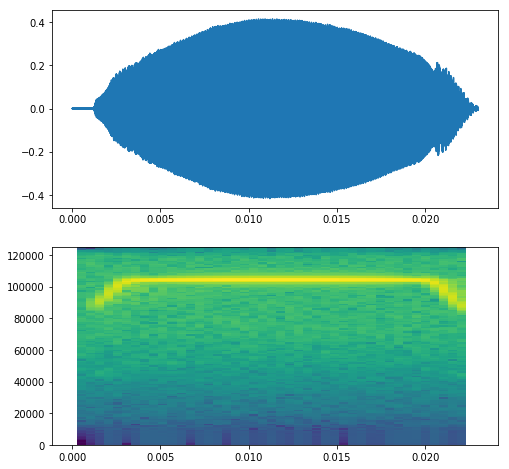

In [4]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(211)
plt.plot(make_time(one_call_bandpassed),one_call_bandpassed)
plt.subplot(212, sharex=a0)
plt.specgram(one_call_bandpassed, Fs=fs, NFFT=256);

Now, let's pass this audio snippet into the ```measure_hbc_call``` function:

In [5]:
# run the segmentation and measurements of a call
sounds, measurements = measure_hbc_call(one_call_bandpassed, fs=fs)

/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


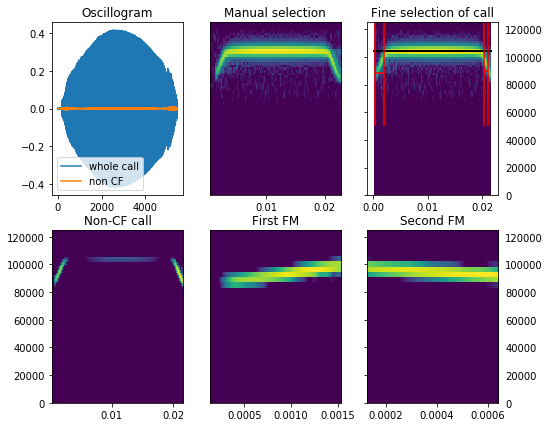

In [6]:
# make the overview figure to check if everything happened as expected
make_overview_figure(one_call_bandpassed, sounds, measurements, fs=250000, dyn_range=100)

### The overview figure and its subplots:

This is a viewing tool built to help the user decide whether the call has been segmented clearly. 

* Oscillogram: The waveform of the raw (blue) audio and the audio with CF portion removed (orange). 

* Manual selection : The exact waveform chosen by the user

* Fine selection of call : The 95%ile energy window of the manually selected window. This step narrows the time window the manual selection a little bit more. 

* Non-CF call : A spectrogram of the audio with CF portion filter out. 

* First FM : For horseshoe bat calls, this si typically an upward modulated FM segment. 

* Second FM : This is typically a downward FM segment. 

In [7]:
len(sounds)

4

### The output sounds 
The output sounds are typically: 1) the fine selection audio 2) audio with CF part removed 3) rising FM 4) rising FM. Depending on the number of FM portions detected in a call, there may only be 2,3 or 4 output sounds. The first two sounds are however always the fine audio selection and CF-filtered call. 

In [8]:
fine_selection, cf_filtered, fm_rising, fm_descending = sounds

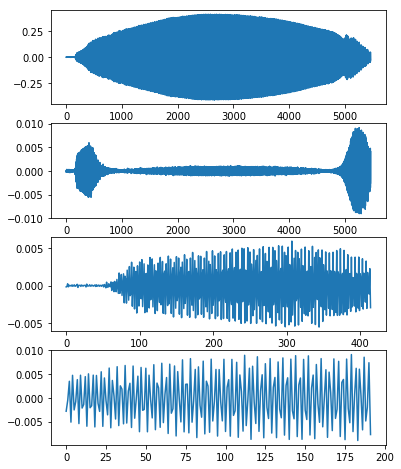

In [9]:
plt.figure(figsize=(6,8))
plt.subplot(411)
plt.plot(fine_selection)
plt.subplot(412)
plt.plot(cf_filtered)
plt.subplot(413)
plt.plot(fm_rising)
plt.subplot(414)
plt.plot(fm_descending)

In [10]:
# print the measurements
measurements

,call_duration,call_energy,call_rms,cf_duration,cf_energy,cf_rms,downfm_end_time,downfm_energy,downfm_rms,downfm_start_time,downfm_terminal_frequency,peak_frequency,upfm_end_time,upfm_energy,upfm_rms,upfm_start_time,upfm_terminal_frequency
0,0.021844,268.51852,0.221744,0.019416,268.50252,0.235193,0.021072,0.006163,0.005666,0.020304,89843.75,104492.1875,0.002068,0.00354,0.002921,0.000408,88554.216867


### Choosing the right parameter settings for *your* bat calls!
The segmentation is of course affected by the parameter settings given to ```measure_hbc_call ```. The current default set may be good for many situations - but you may want better! 

### How does the call segmentation work?
The call segmentation works on the fact that horseshoe bat calls have most of their energy in one part of their call, the constant frequency (CF) part. The CF part of a call is typically flanked by two FMs. ```mesaure_hbc_call ``` goes through the following steps for every input audio. 

* 1. Narrow time-window of manual selection of audio by selecting a 95% energy window

* 2. Detect peak frequency and apply notch filter at this peak frequency 

* 3. See if there is any signal above noise threshold remaining after notch-filtering. If there are regions of the signal above threshold, then they are assumed to the FM parts. 

* 4. Perform peak detection and identify FM parts

* 5. Perform measurements on identified FM parts and whole call. 

* 6. Output segmented call and its parts. 

### Feedback and Contributions Welcome!! 
### Thejasvi Beleyur,  Acoustic and Functional Ecology Group, Max Planck Institute for Ornithology, Seewiesen

-- Last updated 2020-02-14 15:30 CET